In [1]:
import numpy as np
import pandas as pd 
import cv2 
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# [Keep your existing data loading and DentalImageGenerator class code the same]
df_valid = pd.read_csv('C:/Users/Saranya/OneDrive/Documents/final_year_project/image_train/valid/valid.csv')
df_test = pd.read_csv('C:/Users/Saranya/OneDrive/Documents/final_year_project/image_train/test/test.csv')
df_train = pd.read_csv('C:/Users/Saranya/OneDrive/Documents/final_year_project/image_train/train/train.csv')

# Process each dataset
for df in [df_valid, df_test, df_train]:
    df['cropped_image_width'] = df['xmax'] - df['xmin']
    df['cropped_image_height'] = df['ymax'] - df['ymin']
    df['Area'] = df['cropped_image_width'] * df['cropped_image_height']
    df = df[(df.Area >= df.Area.quantile(0.25)) & (df.Area <= df.Area.quantile(0.75))]

class DentalImageGenerator(Sequence):
    def __init__(self, df, base_path, batch_size=32, dim=(224, 224), n_channels=3, n_classes=4, shuffle=True):
        self.df = df
        self.base_path = base_path
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.label_encoder = LabelEncoder()
        self.on_epoch_end()
        
        # Fit label encoder on all classes
        all_classes = self.df['class'].unique()
        self.label_encoder.fit(all_classes)

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        # Initialization
        X = np.empty((len(indexes), *self.dim, self.n_channels))
        y = np.empty((len(indexes)), dtype=int)

        # Generate data
        for i, idx in enumerate(indexes):
            row = self.df.iloc[idx]
            
            # Load and process image
            try:
                img_path = os.path.join(self.base_path, row['filename'])
                image = cv2.imread(img_path)
                
                if image is not None:
                    # Convert coordinates to integers and ensure they're within bounds
                    ymin = max(0, int(row['ymin']))
                    ymax = min(int(row['ymax']), image.shape[0])
                    xmin = max(0, int(row['xmin']))
                    xmax = min(int(row['xmax']), image.shape[1])
                    
                    # Crop and process image
                    cropped = image[ymin:ymax, xmin:xmax]
                    resized = cv2.resize(cropped, self.dim)
                    rgb_image = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
                    
                    # Store processed image
                    X[i,] = rgb_image / 255.0
                    
                    # Store class
                    y[i] = self.label_encoder.transform([row['class']])[0]
            
            except Exception as e:
                print(f"Error processing image {row['filename']}: {str(e)}")
                # Fill with zeros if there's an error
                X[i,] = np.zeros((*self.dim, self.n_channels))
                y[i] = 0

        # Convert class indices to one-hot encoded labels
        y = np.eye(self.n_classes)[y]
        
        return X, y


# Create data generators with data augmentation
train_generator = DentalImageGenerator(
    df_train,
    'C:/Users/Saranya/OneDrive/Documents/final_year_project/image_train/train',
    batch_size=16  # Reduced batch size
)

valid_generator = DentalImageGenerator(
    df_valid,
    'C:/Users/Saranya/OneDrive/Documents/final_year_project/image_train/valid',
    batch_size=16
)

test_generator = DentalImageGenerator(
    df_test,
    'C:/Users/Saranya/OneDrive/Documents/final_year_project/image_train/test',
    batch_size=16,
    shuffle=False
)

# Create improved ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-30:]:  # Unfreeze last 30 layers
    layer.trainable = True

# Add custom layers with dropout and batch normalization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Add callbacks for better training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                             factor=0.2, 
                             patience=3, 
                             min_lr=1e-6)

early_stopping = EarlyStopping(monitor='val_accuracy',
                             patience=10,
                             restore_best_weights=True)

# Train the model with more epochs
history = model.fit(
    train_generator,
    epochs=3,  # Increased epochs
    validation_data=valid_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Print final accuracies
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print("\nAccuracy Results:")
print("-" * 50)
print(f"Accuracy: {train_accuracy:.4f}")

# Save the model
model.save('high_accuracy_dental_model_1.h5')

C:\Users\Saranya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
Error processing image 0974_jpg.rf.ff31d35aecfa18f7a3bb61736cb40dcf.jpg: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Error processing image 0974_jpg.rf.08aa86b32941f04af43189a63b4f6683.jpg: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Error processing image 0974_jpg.rf.1106191cfb2fa2d640fa75593eeb8122.jpg: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

502/502 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6964 - loss: 0.9394  

C:\Users\Saranya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


502/502 ━━━━━━━━━━━━━━━━━━━━ 3643s 7s/step - accuracy: 0.6967 - loss: 0.9388 - val_accuracy: 0.0551 - val_loss: 4.8913 - learning_rate: 1.0000e-04
Epoch 2/3
Error processing image 0974_jpg.rf.08aa86b32941f04af43189a63b4f6683.jpg: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Error processing image 0974_jpg.rf.1106191cfb2fa2d640fa75593eeb8122.jpg: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Error processing image 0974_jpg.rf.ff31d35aecfa18f7a3bb61736cb40dcf.jpg: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

502/502 ━━━━━━━━━━━━━━━━━━━━ 6940s 14s/step - accuracy: 0.9128 - loss: 0.2869 - val_accuracy: 0.6154 - val_loss: 1.0873 - learning_r


Accuracy Results:
--------------------------------------------------
Accuracy: 0.9345


Generating predictions...


C:\Users\Saranya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step 

Generating confusion matrix...


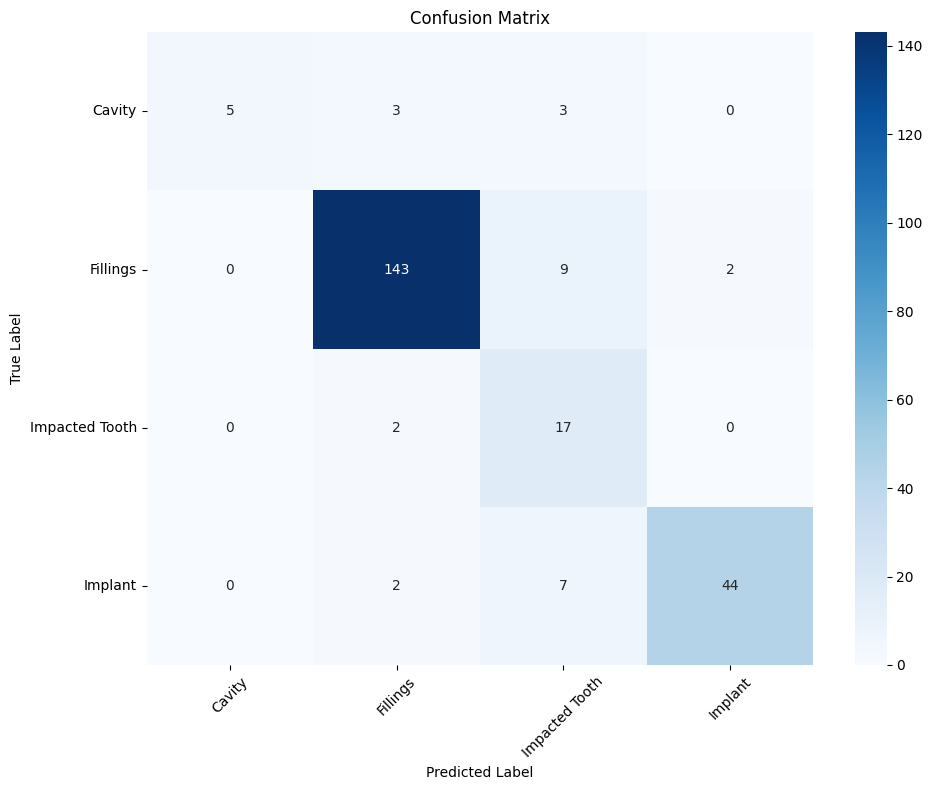


Detailed Classification Report:
--------------------------------------------------
                precision    recall  f1-score   support

        Cavity       1.00      0.45      0.62        11
      Fillings       0.95      0.93      0.94       154
Impacted Tooth       0.47      0.89      0.62        19
       Implant       0.96      0.83      0.89        53

      accuracy                           0.88       237
     macro avg       0.85      0.78      0.77       237
  weighted avg       0.92      0.88      0.89       237


Summary Metrics:
--------------------------------------------------
F1 Score (weighted): 0.8887
Precision (weighted): 0.9176
Recall (weighted): 0.8819

Per-Class Metrics:
--------------------------------------------------

Class: Cavity
F1 Score: 0.6250
Precision: 1.0000
Recall: 0.4545

Class: Fillings
F1 Score: 0.9408
Precision: 0.9533
Recall: 0.9286

Class: Impacted Tooth
F1 Score: 0.6182
Precision: 0.4722
Recall: 0.8947

Class: Implant
F1 Score: 0.8889
Prec

In [3]:
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# First, define the DentalImageGenerator class
class DentalImageGenerator(Sequence):
    def __init__(self, df, base_path, batch_size=32, dim=(224, 224), n_channels=3, n_classes=4, shuffle=True):
        self.df = df
        self.base_path = base_path
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.label_encoder = LabelEncoder()
        self.on_epoch_end()
        
        # Fit label encoder on all classes
        all_classes = self.df['class'].unique()
        self.label_encoder.fit(all_classes)

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X = np.empty((len(indexes), *self.dim, self.n_channels))
        y = np.empty((len(indexes)), dtype=int)

        for i, idx in enumerate(indexes):
            row = self.df.iloc[idx]
            try:
                img_path = os.path.join(self.base_path, row['filename'])
                image = cv2.imread(img_path)
                
                if image is not None:
                    ymin = max(0, int(row['ymin']))
                    ymax = min(int(row['ymax']), image.shape[0])
                    xmin = max(0, int(row['xmin']))
                    xmax = min(int(row['xmax']), image.shape[1])
                    
                    cropped = image[ymin:ymax, xmin:xmax]
                    resized = cv2.resize(cropped, self.dim)
                    rgb_image = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
                    
                    X[i,] = rgb_image / 255.0
                    y[i] = self.label_encoder.transform([row['class']])[0]
            
            except Exception as e:
                print(f"Error processing image {row['filename']}: {str(e)}")
                X[i,] = np.zeros((*self.dim, self.n_channels))
                y[i] = 0

        y = np.eye(self.n_classes)[y]
        return X, y

# Now load the model and evaluate
# Load the saved model
model = load_model('high_accuracy_dental_model_1.h5')

# Load and process test data
df_test = pd.read_csv('C:/Users/Saranya/OneDrive/Documents/final_year_project/image_train/test/test.csv')
df_test['cropped_image_width'] = df_test['xmax'] - df_test['xmin']
df_test['cropped_image_height'] = df_test['ymax'] - df_test['ymin']
df_test['Area'] = df_test['cropped_image_width'] * df_test['cropped_image_height']
df_test = df_test[(df_test.Area >= df_test.Area.quantile(0.25)) & (df_test.Area <= df_test.Area.quantile(0.75))]

# Create test generator
test_generator = DentalImageGenerator(
    df_test,
    'C:/Users/Saranya/OneDrive/Documents/final_year_project/image_train/test',
    batch_size=16,
    shuffle=False
)

# Get predictions
print("Generating predictions...")
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = []
for i in range(len(test_generator)):
    _, y_batch = test_generator[i]
    y_true.extend(np.argmax(y_batch, axis=1))
y_true = y_true[:len(y_pred)]

# Calculate and plot confusion matrix
print("\nGenerating confusion matrix...")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
class_names = test_generator.label_encoder.classes_
plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45)
plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Print metrics
print("\nDetailed Classification Report:")
print("-" * 50)
print(classification_report(y_true, y_pred, target_names=class_names))

# Calculate and print summary metrics
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print("\nSummary Metrics:")
print("-" * 50)
print(f"F1 Score (weighted): {f1:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")

# Print per-class metrics
per_class_f1 = f1_score(y_true, y_pred, average=None)
per_class_precision = precision_score(y_true, y_pred, average=None)
per_class_recall = recall_score(y_true, y_pred, average=None)

print("\nPer-Class Metrics:")
print("-" * 50)
for i, class_name in enumerate(class_names):
    print(f"\nClass: {class_name}")
    print(f"F1 Score: {per_class_f1[i]:.4f}")
    print(f"Precision: {per_class_precision[i]:.4f}")
    print(f"Recall: {per_class_recall[i]:.4f}")

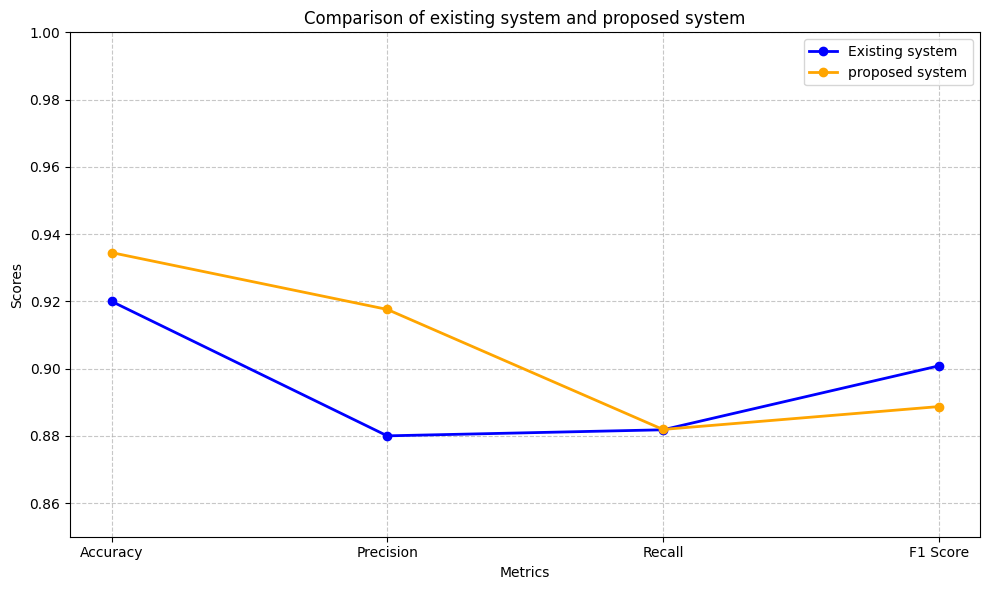

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics from the base paper (EfficientNet-b0)
base_paper_metrics = {
    'Accuracy': 0.92,
    'Precision': 0.88,
    'Recall': 0.8818,
    'F1 Score': 0.9008
}

# Metrics from your implementation
your_implementation_metrics = {
    'Accuracy': 0.9345,
    'Precision': 0.9176,
    'Recall': 0.8819,
    'F1 Score': 0.8887
}

# Extract the metrics for plotting
metrics = list(base_paper_metrics.keys())
base_paper_values = list(base_paper_metrics.values())
your_implementation_values = list(your_implementation_metrics.values())

# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Create x-axis points
x = np.arange(len(metrics))

# Plot the lines
plt.plot(x, base_paper_values, 'o-', linewidth=2, label='Existing system', color='blue')
plt.plot(x, your_implementation_values, 'o-', linewidth=2, label='proposed system', color='orange')

# Add value labels above the points
#for i, v in enumerate(base_paper_values):
#    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
#for i, v in enumerate(your_implementation_values):
#    plt.text(i, v - 0.02, f'{v:.2f}', ha='center', va='top')

# Customize the plot
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of existing system and proposed system')
plt.xticks(x, metrics)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Set y-axis limits to better show the differences
plt.ylim(0.85, 1.0)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()